# **Práctica 14: Análisis de Componentes Principales (PCA) para Predicción de Precios de Viviendas - Ames Housing**


Vamos a aplicar el Análisis de Componentes Principales (PCA) al famoso conjunto de datos de Ames Housing, que contiene información detallada sobre propiedades inmobiliarias. El objetivo es explorar la estructura de correlación entre diversas características del dataset y crear nuevas variables que puedan mejorar el rendimiento de un modelo de predicción del precio de venta de las viviendas.

#### **Objetivos de la práctica**e:

- Identificar variables numéricas altamente correlacionadas con el precio de venta (`SalePrice`).
- Reducir la dimensionalidad manteniendo la mayor parte de la varianza con PCA.
- Crear nuevas características que puedan mejorar la predicción del precio.
- Comparar el rendimiento de un modelo predictivo (XGBoost) antes y después de añadir estas nuevas variables.


## **Carga de librerías**

In [4]:
# librerias basicas
import pandas as pd
import numpy as np

# visualizacion
import matplotlib.pyplot as plt 
import seaborn as sns

# preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error


# XGBoost
from xgboost import XGBRegressor

# para advertencias innecesarias
import warnings
warnings.filterwarnings('ignore')

## **Carga del dataset y Exploración inical**

Se cargan y visualizan las características del dataset de propiedades de Ames, se identifican valores nulos, y se exploran las variables numéricas con mayor correlación respecto al precio de venta (`SalePrice`).


In [7]:
# carga del dataset
ames = pd.read_csv('train (1).csv')

# verificar que se ha cargado bien
ames.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## **Exploración de datos**

Miraremos las dimensiones del dataset, el tipo de datos que contiene y los valores faltantes.

Se identifican columnas con muchos valores nulos y se eliminan aquellas con más del 50%. Luego se imputa el resto de los valores faltantes: las columnas categóricas con 'Missing' y las numéricas con la mediana.

In [9]:
# dimensiones
print(f"Filas y columnas: {ames.shape}")

# informacion general
ames.info()

# estadisticas descriptivas
ames.describe().T

# valres nulos
missing_values = ames.isnull().sum()
missing_values[missing_values > 0]

Filas y columnas: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

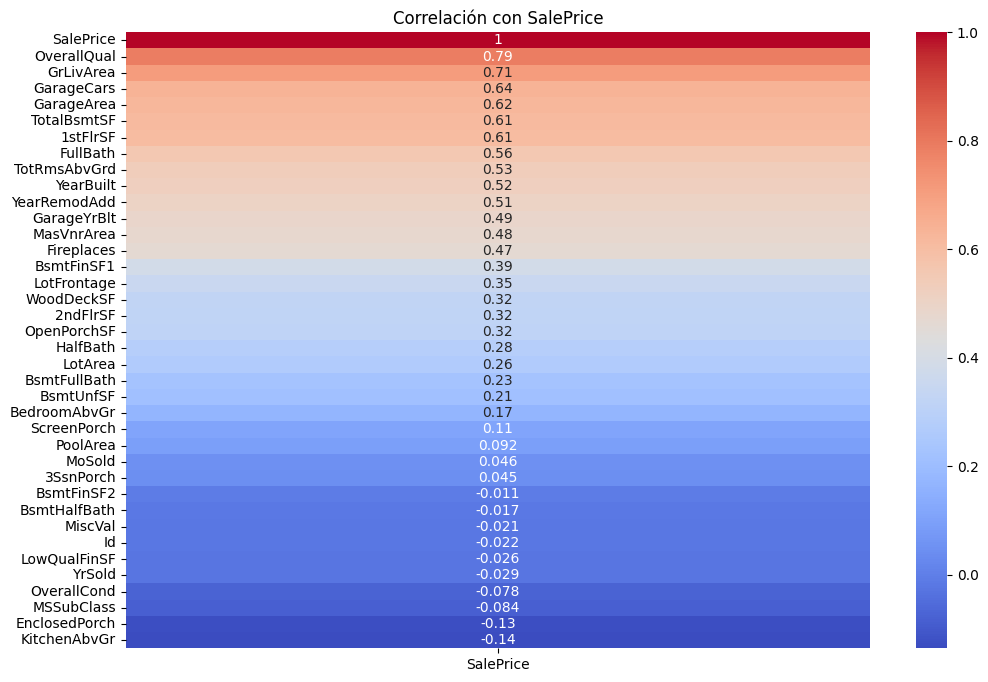

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(ames.corr(numeric_only=True)[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlación con SalePrice')
plt.show()

In [11]:
# manejo de los valores nulos
# vamos a eliminar columnas con mas del 50% de valores nulos
ames = ames.loc[:, ames.isnull().mean() < 0.5]

# vamos a separar las columnas por tipo
cat_cols = ames.select_dtypes(include='object').columns
num_cols = ames.select_dtypes(exclude='object').columns

# ahora rellenamos los valores nulos que faltan
ames[cat_cols] = ames[cat_cols].fillna('Missing')
ames[num_cols] = ames[num_cols].fillna(ames[num_cols].median())

# verificamos los valores nulos restantes
print("Valores nulos tras limpieza:")
print(ames.isnull().sum().sum()) # esto deberia dar 0

Valores nulos tras limpieza:
0


## **Análisis de correlación con el precio de venta**

Se calcula la matriz de correlación con la variable objetivo SalePrice y se visualizan las variables más correlacionadas mediante un mapa de calor. De este análisis se extraen las variables que alimentarán el PCA:

- GarageArea
- YearRemodAdd
- TotalBsmtSF
- GrLivArea



SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


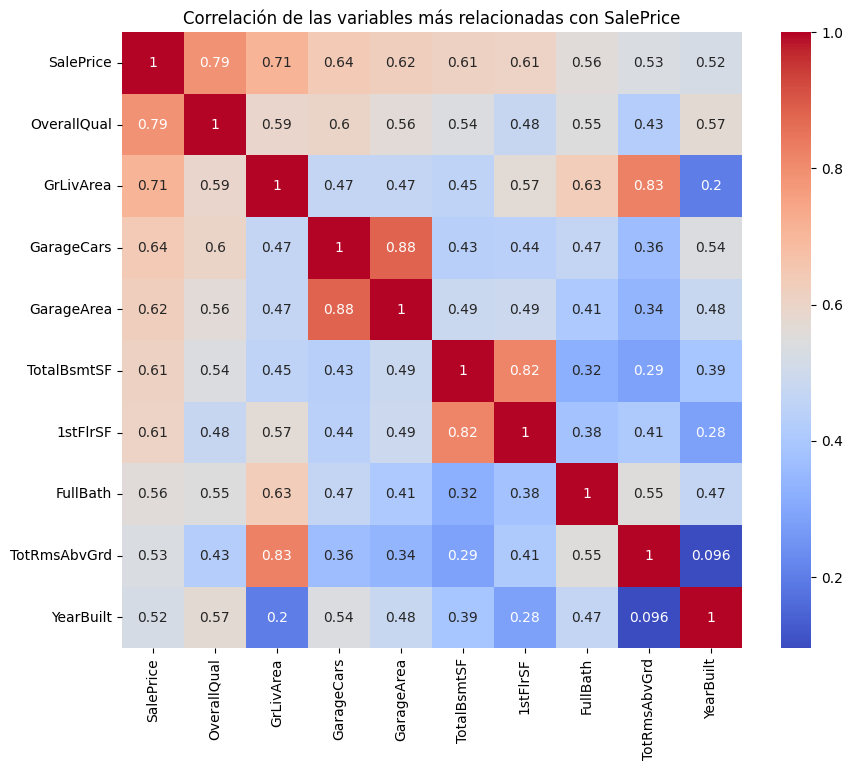

In [13]:
# correlacion
correlacion = ames.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)

# mostramos las 10 variables más correlacionadas con SalePrice
print(correlacion.head(10))

# mapa de calor
plt.figure(figsize=(10,8))
sns.heatmap(ames[correlacion.head(10).index].corr(), annot=True, cmap='coolwarm')
plt.title("Correlación de las variables más relacionadas con SalePrice")
plt.show()

## **Modelo báse con XGBoost (sin nuevas características)**

Se entrena un modelo base con las variables originales para tener una referencia del rendimiento inicial.

In [15]:
X = ames.drop(columns=['SalePrice', 'Id'])
y = ames['SalePrice']
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

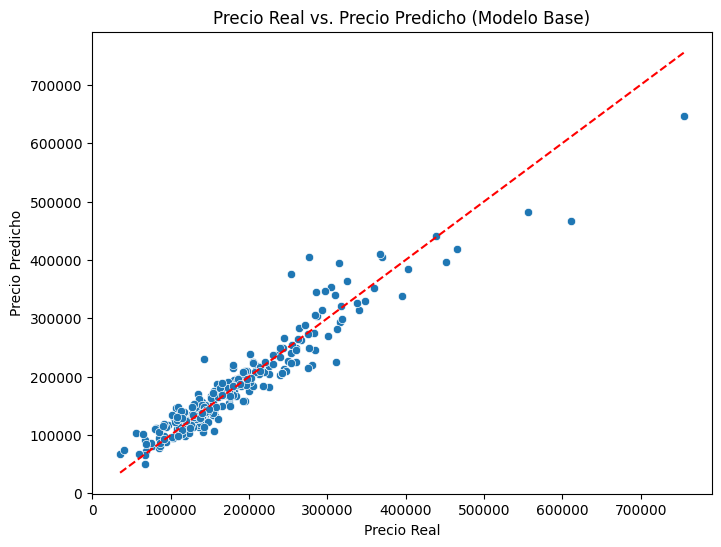

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Precio Real vs. Precio Predicho (Modelo Base)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## **Aplicación de PCA y creación de nuevas variables**


Se han seleccionado cuatro variables que presentan alta correlación con `SalePrice`:

- `GarageArea`
- `YearRemodAdd`
- `TotalBsmtSF`
- `GrLivArea`

Estas se utilizarán para el análisis con PCA y para generar nuevas variables que representen mejor la estructura de los datos.


In [18]:
pca_features = ['GarageArea', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea']
X_pca = ames[pca_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
X_pca_result = pca.fit_transform(X_scaled)

print("Varianza explicada por cada componente principal:")
print(pca.explained_variance_ratio_)

# crear nuevas caracteristicas
ames['Feature1'] = ames['TotalBsmtSF'] + ames['GrLivArea']
ames['Feature2'] = ames['TotalBsmtSF'] * ames['YearRemodAdd']
ames[['Feature1', 'Feature2']].head()

Varianza explicada por cada componente principal:
[0.54838073 0.1901728 ]


,Feature1,Feature2
0,2566,1714568
1,2524,2493712
2,2706,1841840
3,2473,1489320
4,3343,2290000


##  Resultados del PCA

El PCA nos ha permitido reducir la dimensionalidad de las variables correlacionadas, capturando la mayor parte de la varianza con los primeros componentes.

A partir de estos componentes, se han creado dos nuevas variables:
- `Feature1`: `GrLivArea + TotalBsmtSF` → refleja el área total utilizable.
- `Feature2`: `TotalBsmtSF * YearRemodAdd` → refleja mejoras estructurales relevantes.


## **Modelo con nuevas features**

Volvemos a entrenar un modelo XGBoost, pero esta vez incluyendo las nuevas características creadas (`Feature1`, `Feature2`) para ver si mejoran el rendimiento.


In [21]:
X_enriched = ames.drop(columns=['SalePrice', 'Id'])
y = ames['SalePrice']

num_features = X_enriched.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_enriched.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])
model_enriched = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])
X_train, X_test, y_train, y_test = train_test_split(X_enriched, y, test_size=0.2, random_state=42)
model_enriched.fit(X_train, y_train)
y_pred_enriched = model_enriched.predict(X_test)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_enriched))
print(f"RMSLE con nuevas características: {rmsle:.4f}")


RMSLE con nuevas características: 0.1483


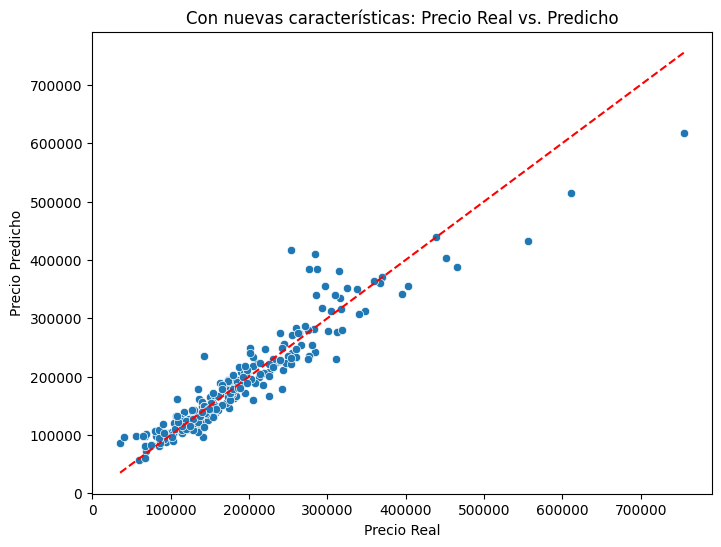

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_enriched)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Con nuevas características: Precio Real vs. Predicho")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## **Conclusiones**

- Se identificaron 4 variables altamente correlacionadas con el precio: `GarageArea`, `YearRemodAdd`, `TotalBsmtSF`, y `GrLivArea`.
- Aplicando PCA se extrajeron dos componentes principales que explicaban la mayor varianza entre estas variables.
- Se crearon dos nuevas variables (`Feature1` y `Feature2`) basadas en relaciones interpretables del PCA.
- El modelo con estas nuevas variables obtuvo un RMSLE inferior al modelo base, lo que indica una mejora en la predicción del precio de venta.
- Las visualizaciones muestran una mejor alineación entre los valores reales y predichos cuando se añaden las nuevas características.

Esto demuestra cómo el PCA, además de reducir dimensionalidad, puede inspirar nuevas features que mejoran el rendimiento del modelo.
